Iñigo Martin Melero

## Participante 17

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_17_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


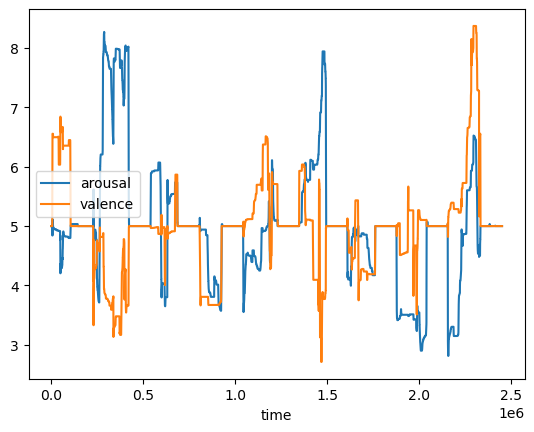

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_17_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.692  37.485  40.766  30.311  22.781     6.549     8.438   
1              1  0.678  37.611  40.747  30.340  22.792     6.672     8.684   
2              2  0.665  37.737  40.727  30.369  22.802     6.795     8.931   
3              3  0.659  37.659  40.731  30.369  22.802     6.795     8.890   
4              4  0.665  37.591  40.755  30.388  22.813     6.877     9.054   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.741  36.090  14.166  31.463  22.676     4.988     6.631   
2451580  2451580  0.744  36.206  14.138  31.463  22.669     5.030     6.713   
2451581  2451581  0.751  35.877  14.150  31.443  22.669     5.070     6.672   
2451582  2451582  0.767  35.974  14.166  31.453  22.672     4.947     6.672   
2451583  2451583  0.767  36.109  14.138  31.443  22.672     4.988     6.631   

         emg_trap  video  
0          11.970     10

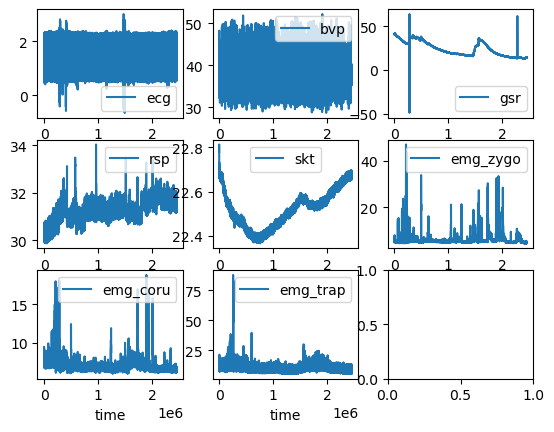

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

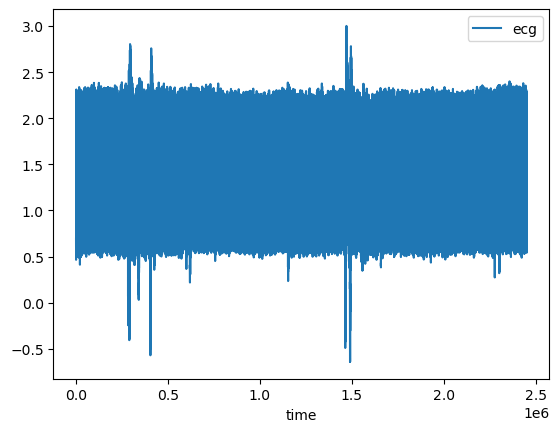

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

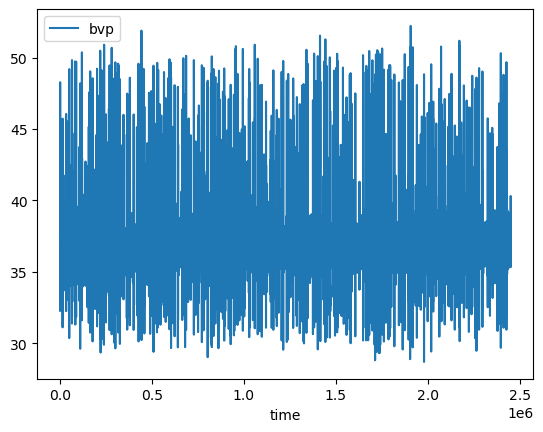

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

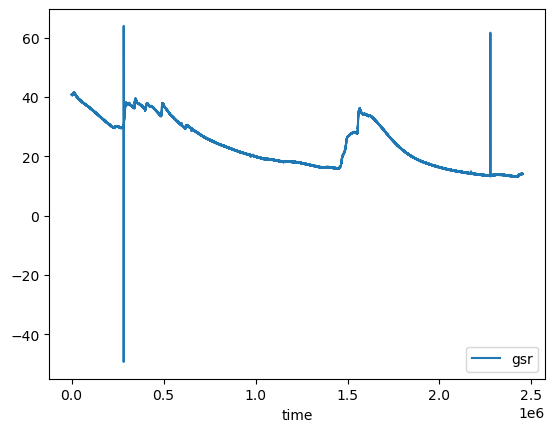

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

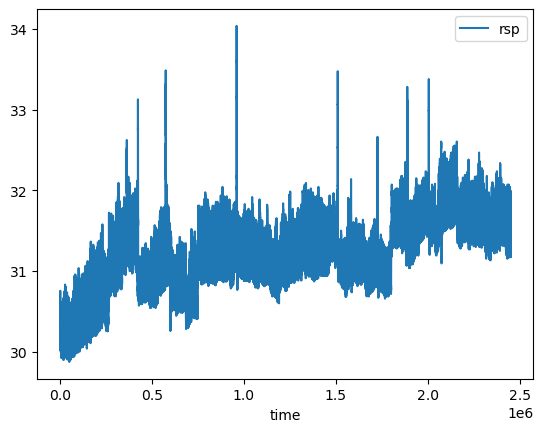

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

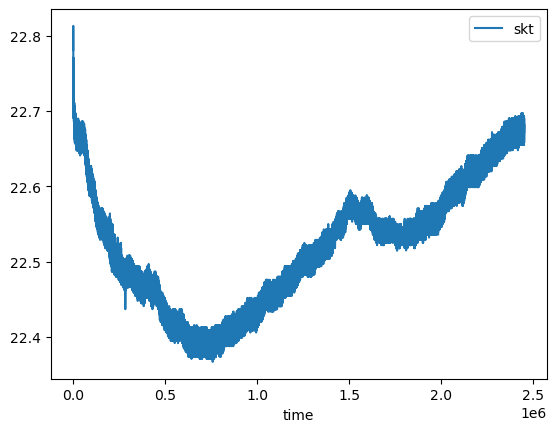

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

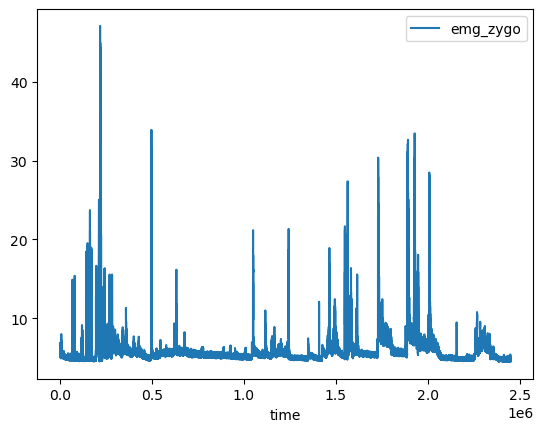

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

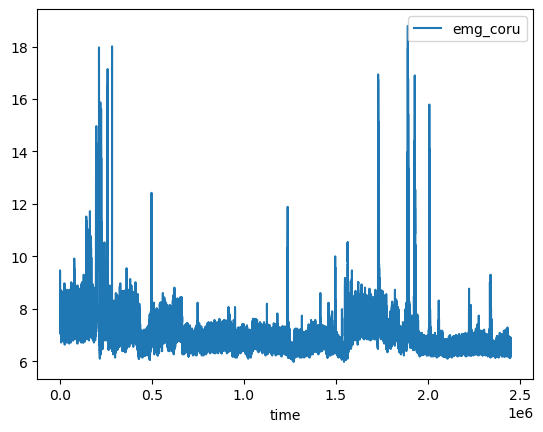

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

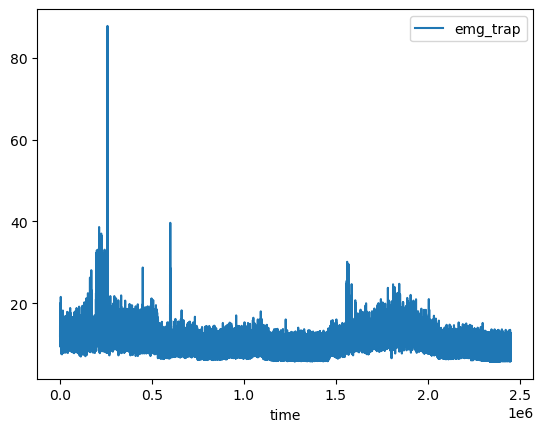

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

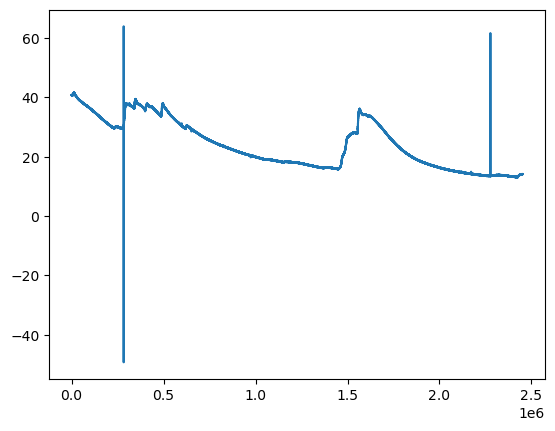

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

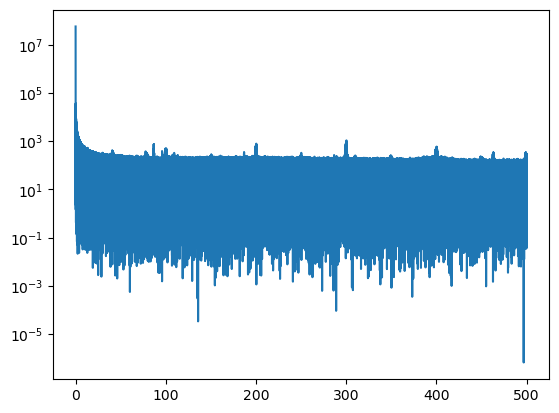

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

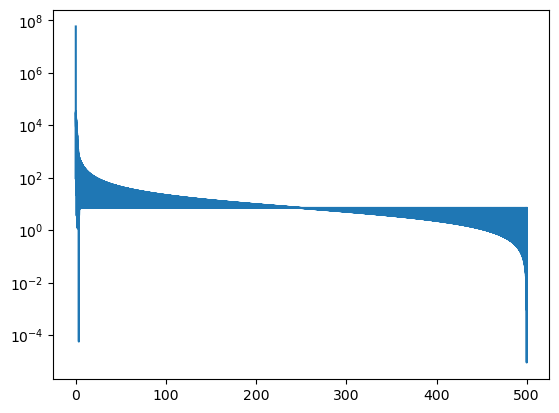

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

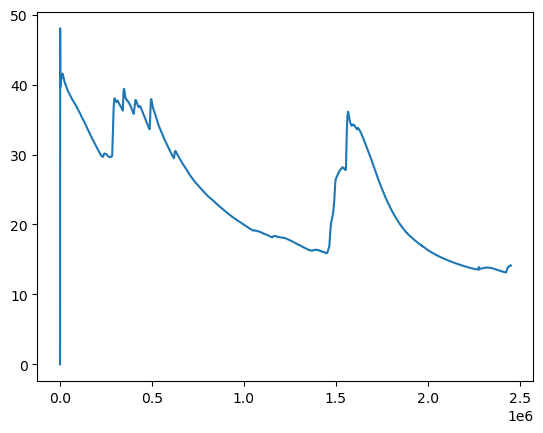

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  14.141
2451580  14.141
2451581  14.141
2451582  14.141
2451583  14.141

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

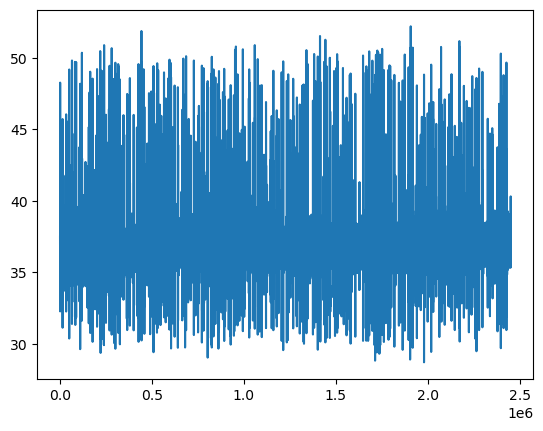

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

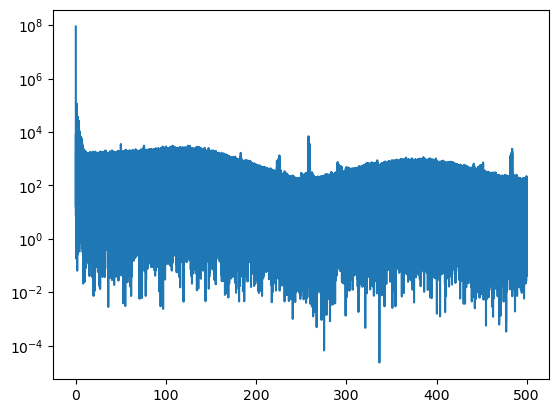

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

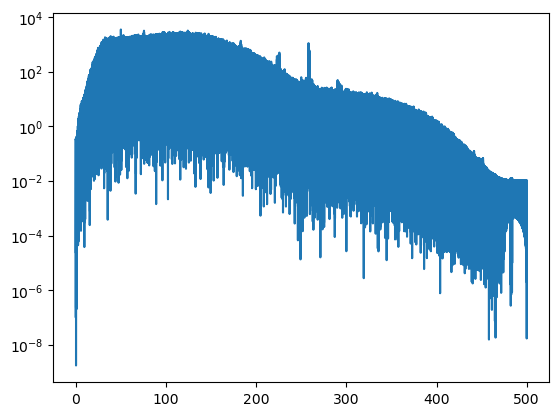

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

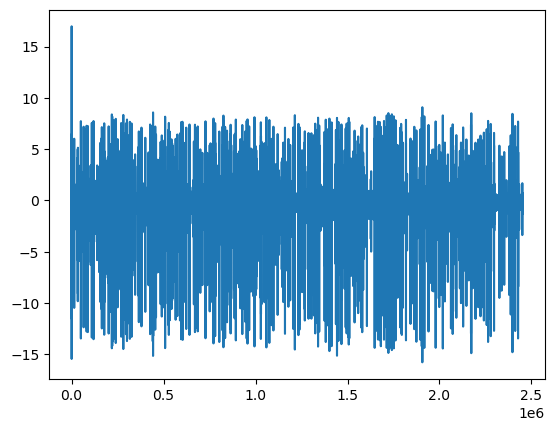

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.042
1        42.814
2        50.694
3        53.967
4        46.544
...         ...
2451579  36.925
2451580  36.895
2451581  36.899
2451582  36.946
2451583  36.976

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

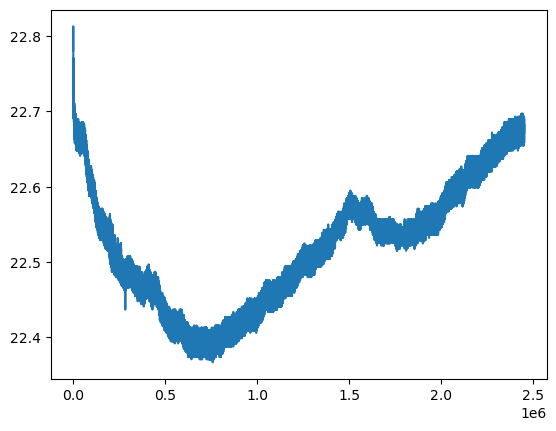

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

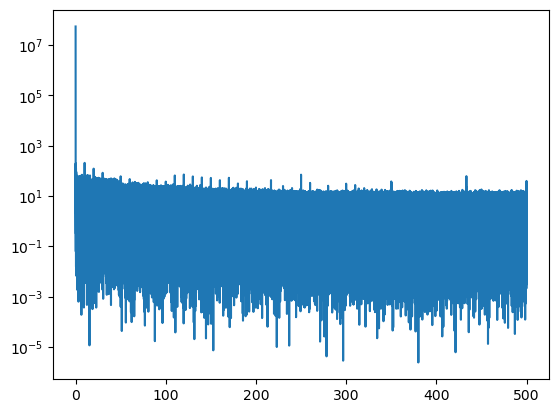

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

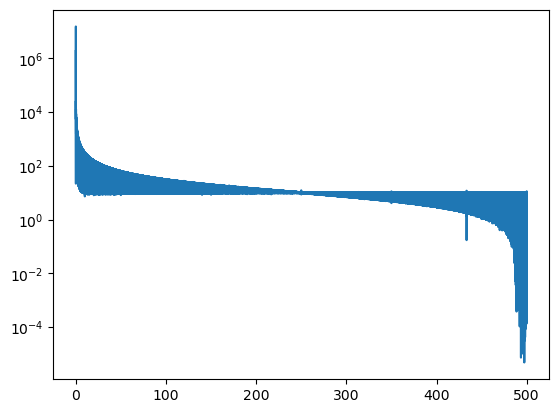

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

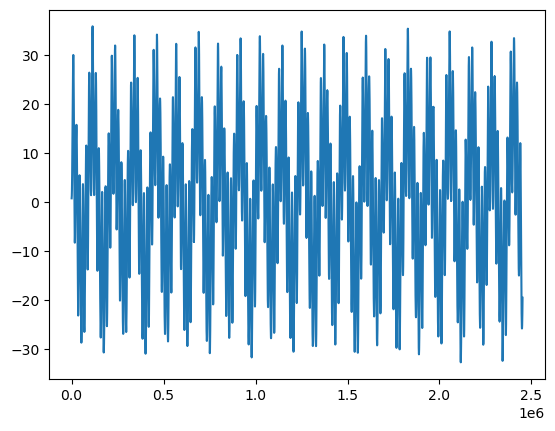

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.730
1        40.730
2        40.731
3        40.731
4        40.731
...         ...
2451579  20.469
2451580  20.473
2451581  20.476
2451582  20.480
2451583  20.484

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.692  30.311     6.549     8.438    11.970     10
1              1  0.678  30.340     6.672     8.684    12.134     10
2              2  0.665  30.369     6.795     8.931    12.298     10
3              3  0.659  30.369     6.795     8.890    12.381     10
4              4  0.665  30.388     6.877     9.054    12.586     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.741  31.463     4.988     6.631    11.970     12
2451580  2451580  0.744  31.463     5.030     6.713    11.929     12
2451581  2451581  0.751  31.443     5.070     6.672    11.806     12
2451582  2451582  0.767  31.453     4.947     6.672    11.764     12
2451583  2451583  0.767  31.443     4.988     6.631    11.683     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.692  30.311     6.549     8.438    11.970     10  38.042   
1              1  0.678  30.340     6.672     8.684    12.134     10  42.814   
2              2  0.665  30.369     6.795     8.931    12.298     10  50.694   
3              3  0.659  30.369     6.795     8.890    12.381     10  53.967   
4              4  0.665  30.388     6.877     9.054    12.586     10  46.544   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.741  31.463     4.988     6.631    11.970     12  36.925   
2451580  2451580  0.744  31.463     5.030     6.713    11.929     12  36.895   
2451581  2451581  0.751  31.443     5.070     6.672    11.806     12  36.899   
2451582  2451582  0.767  31.453     4.947     6.672    11.764     12  36.946   
2451583  2451583  0.767  31.443     4.988     6.631    11.683     12  36.976   

            gsr     skt  
0         0.000  40.730  
1         0.000  40.730  
2         0.000  40.731  
3         0.000  40.731  
4         0.000  40.731  
...         ...     ...  
2451579  14.141  20.469  
2451580  14.141  20.473  
2451581  14.141  20.476  
2451582  14.141  20.480  
2451583  14.141  20.484  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.497667  0.634283  0.635078  0.793136  0.035880  0.030153   
221502    221502  0.449904  0.634202  0.635078  0.793059  0.035880  0.030153   
221503    221503  0.417513  0.631346  0.635078  0.792982  0.029694  0.032256   
221504    221504  0.392259  0.629294  0.635078  0.792905  0.020724  0.028075   
221505    221505  0.371397  0.632633  0.635078  0.792828  0.023817  0.028075   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.474334  0.634202  0.010706  0.356040  0.481905  0.038489   
2331580  2331580  0.472413  0.632875  0.010706  0.356132  0.481905  0.038489   
2331581  2331581  0.475981  0.633036  0.010706  0.356209  0.481905  0.038489   
2331582  2331582  0.472413  0.633156  0.010706  0.356286  0.487782  0.038489   
2331583  2331583  0.471589  0.632674  0.010706  0.356378  0.484998  0.040567   

         emg_coru  emg_trap  video  
221501   0.038975  0.071575      7  
221502   0.032493  0.073074      7  
221503   0.032493  0.074585      7  
221504   0.026010  0.075584      7  
221505   0.019527  0.075584      7  
...           ...       ...    ...  
2331579  0.029251  0.009518      2  
2331580  0.032493  0.009018      2  
2331581  0.026010  0.009518      2  
2331582  0.029251  0.009018      2  
2331583  0.032493  0.010018      2  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.497667  0.634283  0.635078  0.035880  0.793136  0.030153   
221502    221502  0.449904  0.634202  0.635078  0.035880  0.793059  0.030153   
221503    221503  0.417513  0.631346  0.635078  0.029694  0.792982  0.032256   
221504    221504  0.392259  0.629294  0.635078  0.020724  0.792905  0.028075   
221505    221505  0.371397  0.632633  0.635078  0.023817  0.792828  0.028075   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.474334  0.634202  0.010706  0.481905  0.356040  0.038489   
2331580  2331580  0.472413  0.632875  0.010706  0.481905  0.356132  0.038489   
2331581  2331581  0.475981  0.633036  0.010706  0.481905  0.356209  0.038489   
2331582  2331582  0.472413  0.633156  0.010706  0.487782  0.356286  0.038489   
2331583  2331583  0.471589  0.632674  0.010706  0.484998  0.356378  0.040567   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.376064  0.636294  0.635078  0.032787  0.791690  0.024958  0.026010   
221540   0.378809  0.637219  0.635078  0.029694  0.790151  0.022880  0.038975   
221560   0.376887  0.635369  0.635078  0.038664  0.788613  0.019764  0.038975   
221580   0.382377  0.634524  0.635078  0.023817  0.787075  0.011428  0.022769   
221600   0.387593  0.603307  0.635039  0.029694  0.785536  0.012492  0.022769   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.408455  0.637984  0.010667  0.499845  0.349471  0.038489  0.026010   
2331520  0.415592  0.633197  0.010706  0.490875  0.351132  0.038489  0.029251   
2331540  0.430963  0.631386  0.010706  0.493968  0.352809  0.042644  0.032493   
2331560  0.449904  0.641202  0.010706  0.490875  0.354470  0.038489  0.035734   
2331580  0.472413  0.632875  0.010706  0.481905  0.356132  0.038489  0.032493   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.376064  0.636294  0.635078  0.032787  0.791690  0.024958  0.026010   
1      0.378809  0.637219  0.635078  0.029694  0.790151  0.022880  0.038975   
2      0.376887  0.635369  0.635078  0.038664  0.788613  0.019764  0.038975   
3      0.382377  0.634524  0.635078  0.023817  0.787075  0.011428  0.022769   
4      0.387593  0.603307  0.635039  0.029694  0.785536  0.012492  0.022769   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.408455  0.637984  0.010667  0.499845  0.349471  0.038489  0.026010   
63500  0.415592  0.633197  0.010706  0.490875  0.351132  0.038489  0.029251   
63501  0.430963  0.631386  0.010706  0.493968  0.352809  0.042644  0.032493   
63502  0.449904  0.641202  0.010706  0.490875  0.354470  0.038489  0.035734   
63503  0.472413  0.632875  0.010706  0.481905  0.356132  0.038489  0.032493   

       emg_trap  valence  arousal  
0      0.102603    5.000    5.000  
1      0.097107    5.000    5.000  
2      0.087089    5.000    5.000  
3      0.052063    5.000    5.000  
4      0.041046    5.000    5.000  
...         ...      ...      ...  
63499  0.018524    6.534    4.502  
63500  0.013528    6.534    4.502  
63501  0.011517    6.534    4.502  
63502  0.010018    6.534    4.502  
63503  0.009018    6.534    4.502  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.376064  0.636294  0.635078  0.032787  0.791690  0.024958  0.026010   
1      0.378809  0.637219  0.635078  0.029694  0.790151  0.022880  0.038975   
2      0.376887  0.635369  0.635078  0.038664  0.788613  0.019764  0.038975   
3      0.382377  0.634524  0.635078  0.023817  0.787075  0.011428  0.022769   
4      0.387593  0.603307  0.635039  0.029694  0.785536  0.012492  0.022769   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.391436  0.627565  0.010628  0.499845  0.342810  0.042644  0.029251   
63496  0.385946  0.633559  0.010628  0.499845  0.344471  0.045761  0.038975   
63497  0.391436  0.634202  0.010628  0.502938  0.346133  0.043709  0.042217   
63498  0.399396  0.632754  0.010667  0.502938  0.347809  0.041605  0.035734   
63499  0.408455  0.637984  0.010667  0.499845  0.349471  0.038489  0.026010   

       emg_trap  valence  arousal  
0      0.102603    5.000    5.000  
1      0.097107    5.000    5.000  
2      0.087089    5.000    5.000  
3      0.052063    5.000    5.000  
4      0.041046    5.000    5.000  
...         ...      ...      ...  
63495  0.070575    6.534    4.502  
63496  0.045056    6.534    4.502  
63497  0.029529    6.534    4.502  
63498  0.021023    6.534    4.502  
63499  0.018524    6.534    4.502  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.376064  0.636294  0.635078  0.032787  0.791690  0.024958  0.026010   
 1   0.378809  0.637219  0.635078  0.029694  0.790151  0.022880  0.038975   
 2   0.376887  0.635369  0.635078  0.038664  0.788613  0.019764  0.038975   
 3   0.382377  0.634524  0.635078  0.023817  0.787075  0.011428  0.022769   
 4   0.387593  0.603307  0.635039  0.029694  0.785536  0.012492  0.022769   
 5   0.396651  0.627605  0.635039  0.023817  0.783983  0.012492  0.019527   
 6   0.412023  0.634444  0.635000  0.044850  0.782460  0.014570  0.038975   
 7   0.418337  0.636455  0.634962  0.038664  0.780906  0.012492  0.038975   
 8   0.432885  0.635329  0.634923  0.044850  0.779352  0.011428  0.038975   
 9   0.454570  0.633961  0.634846  0.035880  0.777798  0.010389  0.016207   
 10  0.484216  0.634323  0.634807  0.050727  0.776245  0.011428  0.016207   
 11  0.511392  0.634323  0.634730  0.053820  0.774691  0.007272  0.012965   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.376064  0.636294  0.635078  0.032787  0.791690  0.024958  0.026010   
1     0.378809  0.637944  0.634150  0.167646  0.752784  0.003117  0.035734   
2     0.427395  0.627927  0.633338  0.353232  0.713664  0.011428  0.038975   
3     0.382377  0.633277  0.632488  0.290442  0.675635  0.049942  0.074709   
4     0.372495  0.634846  0.631754  0.074853  0.639807  0.194573  0.568187   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.380456  0.636737  0.011131  0.377049  0.164375  0.050981  0.038975   
2536  0.337085  0.642369  0.011208  0.368079  0.194588  0.049942  0.026010   
2537  0.381279  0.635168  0.011247  0.332199  0.229586  0.048903  0.038975   
2538  0.396651  0.634765  0.011247  0.323229  0.268291  0.044722  0.055261   
2539  0.376064  0.635329  0.010822  0.377049  0.309335  0.038489  0.029251   

             8         9        10  ...       193       194       195  \
0     0.102603  0.378809  0.637219  ...  0.384024  0.641443  0.634189   
1     0.071075  0.377711  0.637421  ...  0.419160  0.638668  0.633338   
2     0.052063  0.447159  0.633197  ...  0.405710  0.632915  0.632527   
3     0.061569  0.367005  0.635128  ...  0.373319  0.640317  0.631793   
4     0.205219  0.374142  0.635449  ...  0.381279  0.635691  0.630904   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.008019  0.385122  0.634846  ...  0.758441  0.633679  0.011208   
2536  0.046055  0.393906  0.630904  ...  0.383201  0.634725  0.011247   
2537  0.012016  0.381279  0.636375  ...  0.395828  0.633116  0.011247   
2538  0.034039  0.395828  0.632472  ...  0.378809  0.637219  0.010860   
2539  0.009018  0.376887  0.631990  ...  0.408455  0.637984  0.010667   

           196       197       198       199       200  valence  arousal  
0     0.164553  0.754369  0.007272  0.042217  0.058059  5.00000  5.00000  
1     0.350139  0.715218  0.011428  0.029251  0.055061  5.00000  5.00000  
2     0.296319  0.677112  0.030153  0.055261  0.055061  5.00000  5.00000  
3     0.071760  0.641176  0.121750  0.376631  0.243754  5.00000  5.00000  
4     0.044850  0.608347  0.146709  0.298680  0.147647  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.368079  0.193280  0.048903  0.032493  0.011517  5.32192  4.66728  
2536  0.332199  0.228109  0.042644  0.032493  0.005509  5.79884  4.57364  
2537  0.332199  0.266691  0.053058  0.051941  0.050564  6.55792  4.51396  
2538  0.374265  0.307673  0.041605  0.032493  0.010018  6.54416  4.51244  
2539  0.499845  0.349471  0.038489  0.026010  0.018524  6.53400  4.50244  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.376064  0.636294  0.635078  0.032787  0.791690  0.024958  0.026010   
1     0.378809  0.637944  0.634150  0.167646  0.752784  0.003117  0.035734   
2     0.427395  0.627927  0.633338  0.353232  0.713664  0.011428  0.038975   
3     0.382377  0.633277  0.632488  0.290442  0.675635  0.049942  0.074709   
4     0.372495  0.634846  0.631754  0.074853  0.639807  0.194573  0.568187   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.380456  0.636737  0.011131  0.377049  0.164375  0.050981  0.038975   
2536  0.337085  0.642369  0.011208  0.368079  0.194588  0.049942  0.026010   
2537  0.381279  0.635168  0.011247  0.332199  0.229586  0.048903  0.038975   
2538  0.396651  0.634765  0.011247  0.323229  0.268291  0.044722  0.055261   
2539  0.376064  0.635329  0.010822  0.377049  0.309335  0.038489  0.029251   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub17.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.376064  0.636294  0.635078  0.032787  0.791690  0.024958  0.026010   
1     0.378809  0.637944  0.634150  0.167646  0.752784  0.003117  0.035734   
2     0.427395  0.627927  0.633338  0.353232  0.713664  0.011428  0.038975   
3     0.382377  0.633277  0.632488  0.290442  0.675635  0.049942  0.074709   
4     0.372495  0.634846  0.631754  0.074853  0.639807  0.194573  0.568187   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.380456  0.636737  0.011131  0.377049  0.164375  0.050981  0.038975   
2536  0.337085  0.642369  0.011208  0.368079  0.194588  0.049942  0.026010   
2537  0.381279  0.635168  0.011247  0.332199  0.229586  0.048903  0.038975   
2538  0.396651  0.634765  0.011247  0.323229  0.268291  0.044722  0.055261   
2539  0.376064  0.635329  0.010822  0.377049  0.309335  0.038489  0.029251   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub17.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.376064  0.636294  0.635078  0.032787  0.791690  0.024958  0.026010   
1     0.378809  0.637944  0.634150  0.167646  0.752784  0.003117  0.035734   
2     0.427395  0.627927  0.633338  0.353232  0.713664  0.011428  0.038975   
3     0.382377  0.633277  0.632488  0.290442  0.675635  0.049942  0.074709   
4     0.372495  0.634846  0.631754  0.074853  0.639807  0.194573  0.568187   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.380456  0.636737  0.011131  0.377049  0.164375  0.050981  0.038975   
2536  0.337085  0.642369  0.011208  0.368079  0.194588  0.049942  0.026010   
2537  0.381279  0.635168  0.011247  0.332199  0.229586  0.048903  0.038975   
2538  0.396651  0.634765  0.011247  0.323229  0.268291  0.044722  0.055261   
2539  0.376064  0.635329  0.010822  0.377049  0.309335  0.038489  0.029251   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub17.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.376064  0.636294  0.635078  0.032787  0.791690  0.024958  0.026010   
1     0.378809  0.637944  0.634150  0.167646  0.752784  0.003117  0.035734   
2     0.427395  0.627927  0.633338  0.353232  0.713664  0.011428  0.038975   
3     0.382377  0.633277  0.632488  0.290442  0.675635  0.049942  0.074709   
4     0.372495  0.634846  0.631754  0.074853  0.639807  0.194573  0.568187   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.380456  0.636737  0.011131  0.377049  0.164375  0.050981  0.038975   
2536  0.337085  0.642369  0.011208  0.368079  0.194588  0.049942  0.026010   
2537  0.381279  0.635168  0.011247  0.332199  0.229586  0.048903  0.038975   
2538  0.396651  0.634765  0.011247  0.323229  0.268291  0.044722  0.055261   
2539  0.376064  0.635329  0.010822  0.377049  0.309335  0.038489  0.029251   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub17.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.376064  0.636294  0.635078  0.032787  0.791690  0.024958  0.026010   
1     0.378809  0.637944  0.634150  0.167646  0.752784  0.003117  0.035734   
2     0.427395  0.627927  0.633338  0.353232  0.713664  0.011428  0.038975   
3     0.382377  0.633277  0.632488  0.290442  0.675635  0.049942  0.074709   
4     0.372495  0.634846  0.631754  0.074853  0.639807  0.194573  0.568187   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.380456  0.636737  0.011131  0.377049  0.164375  0.050981  0.038975   
2536  0.337085  0.642369  0.011208  0.368079  0.194588  0.049942  0.026010   
2537  0.381279  0.635168  0.011247  0.332199  0.229586  0.048903  0.038975   
2538  0.396651  0.634765  0.011247  0.323229  0.268291  0.044722  0.055261   
2539  0.376064  0.635329  0.010822  0.377049  0.309335  0.038489  0.029251   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub17.csv', index=False)